In [2]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install tensorflow_hub

     |████████████████████████████████| 4.6 MB 24.9 MB/s 
     |████████████████████████████████| 511.7 MB 4.5 kB/s 
     |████████████████████████████████| 5.8 MB 54.0 MB/s 
     |████████████████████████████████| 438 kB 73.8 MB/s 
     |████████████████████████████████| 1.6 MB 57.7 MB/s 
     |████████████████████████████████| 2.1 MB 35.8 MB/s 
     |████████████████████████████████| 92 kB 13.5 MB/s 
     |████████████████████████████████| 47.8 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 65.3 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 237 kB 63.4 MB/s 
     |████████████████████████████████| 636 kB 63.2 MB/s 
     |████████████████████████████████| 352 kB 70.1 MB/s 


In [3]:
!pip install transformers
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras import backend as K
from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy


sns.set_style("whitegrid")


     |████████████████████████████████| 4.2 MB 35.5 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 18.9 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
train = pd.read_csv('train.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train = train.drop(['keyword','location'], axis = 1)

train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print("Shape of Train set:", train.shape)

Shape of Train set: (7613, 3)


In [8]:
df = train.copy()
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

Applying Bert mmodel without any preprocessing steps.

In [9]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4")

In [11]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding(["You are noob.","What are you looking at?"])

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.99035454,  0.9815679 ,  0.99754566, ..., -0.9994888 ,
        -0.5053131 ,  0.94339126],
       [ 0.9989152 ,  0.11918481,  0.89904445, ..., -0.6300099 ,
        -0.9233927 ,  0.934414  ]], dtype=float32)>

In [12]:
num_classes = 2
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers:
l = tf.keras.layers.Dropout(0.2, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(l)

# Construct final model:
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

# You can use these METRICS as well. If you are using this then change 'metrics=METRICS' in 'model.compile' section.
# METRICS = [
#            tf.keras.metrics.BinaryCrossentropy(name='accuracy'),
#            tf.keras.metrics.Precision(name='precision'),
#            tf.keras.metrics.Recall(name='recall')
# ]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

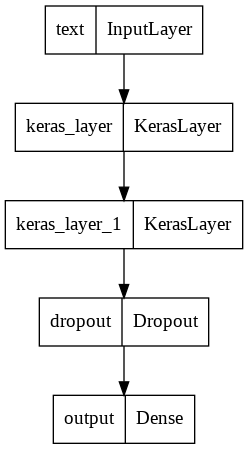

In [13]:
tf.keras.utils.plot_model(model)


In [14]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 198s 1s/step - loss: 0.7153 - accuracy: 0.5798 - val_loss: 0.6572 - val_accuracy: 0.6043
Epoch 2/3
172/172 [==============================] - 181s 1s/step - loss: 0.6809 - accuracy: 0.6125 - val_loss: 0.6226 - val_accuracy: 0.6585
Epoch 3/3
48/48 [==============================] - 45s 926ms/step - loss: 0.5947 - accuracy: 0.7209


[0.59467613697052, 0.7209454774856567]

In [15]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

48/48 [==============================] - 46s 931ms/step
Confusion Matrix
[[660 181]
 [244 438]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       841
           1       0.71      0.64      0.67       682

    accuracy                           0.72      1523
   macro avg       0.72      0.71      0.71      1523
weighted avg       0.72      0.72      0.72      1523



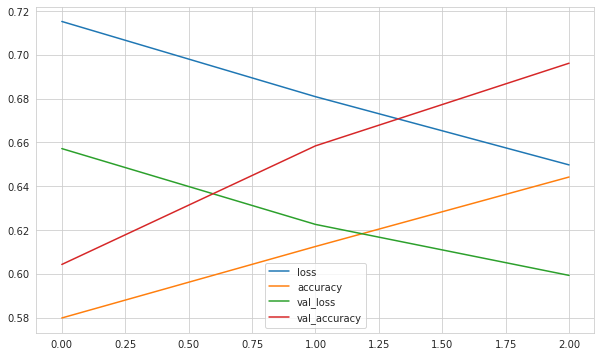

In [16]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

In [17]:
df["CleanText"] = df["text"].apply(lambda x: x.lower())
df.head()

,id,text,target,CleanText
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [18]:
#remove URL
df["CleanText"] = df["CleanText"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "",x))

In [19]:
def removeHTML(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeHTML(x))

In [20]:
#remove emojis
def removeEmojis(text):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeEmojis(x))

In [23]:
from keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
#remove '.'
def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df["CleanText"] = df["CleanText"].apply(lambda x: RemovePunctuation(x))

In [25]:
#remove ascii code

def RemoveASCII(text):
  return re.sub(r'[^\x00-\x7f]', "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: RemoveASCII(x))

In [26]:
df.head()

,id,text,target,CleanText
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [27]:
df['TokenizedText'] = df['CleanText'].apply(nltk.word_tokenize)


In [28]:
display(df.head())

,id,text,target,CleanText,TokenizedText
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


In [29]:
stop = set(stopwords.words('english'))
df['RemoveStopWords'] = df['TokenizedText'].apply(lambda x: [word for word in x if word not in stop])
df.head()

,id,text,target,CleanText,TokenizedText,RemoveStopWords
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [30]:
def doPorterStemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

df['PorterStemmer'] = df['RemoveStopWords'].apply(lambda x: doPorterStemmer(x))
df.head()


,id,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [31]:
def doLemmatizeWord(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in text]
    return lemma

df['LemmatizedText'] = df['RemoveStopWords'].apply(lambda x: doLemmatizeWord(x))
df.head()

,id,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive..."
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of..."
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [32]:
#decide to use WordNetLemmatizer cuz apparently, it is better than stemming.
df['FINAL']=df['LemmatizedText'].apply(lambda x: ''.join(i+' ' for i in x))
df.head()

,id,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText,FINAL
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


In [33]:
df.to_csv("normalized_dataset.csv")

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
cv_df = vectorizer.fit_transform(df['FINAL'])

vectorizer.get_feature_names_out()
print(cv_df.shape)

(7613, 16270)


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(ngram_range = (1,2))
tfidf_df = tfvectorizer.fit_transform(df['FINAL'])
print(tfidf_df.shape)

(7613, 63245)


In [36]:
from gensim.models import Word2Vec, KeyedVectors
import nltk
import multiprocessing

In [37]:
sentences = df['FINAL'].values
#sentences

In [38]:
sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [39]:
w2v_size = 300

**Applying model after Data Preprocessing Steps.**

In [41]:
y = tf.keras.utils.to_categorical(df['target'].astype(str), num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'].astype(str), y, test_size=0.2, random_state=3)

In [42]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 183s 1s/step - loss: 0.6353 - accuracy: 0.6596 - val_loss: 0.5856 - val_accuracy: 0.7274
Epoch 2/3
172/172 [==============================] - 182s 1s/step - loss: 0.6177 - accuracy: 0.6760 - val_loss: 0.5797 - val_accuracy: 0.7159
Epoch 3/3
48/48 [==============================] - 45s 926ms/step - loss: 0.5684 - accuracy: 0.7420


[0.5684158802032471, 0.7419566512107849]

In [43]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

48/48 [==============================] - 45s 957ms/step
Confusion Matrix
[[755  86]
 [307 375]]
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       841
           1       0.81      0.55      0.66       682

    accuracy                           0.74      1523
   macro avg       0.76      0.72      0.72      1523
weighted avg       0.76      0.74      0.73      1523



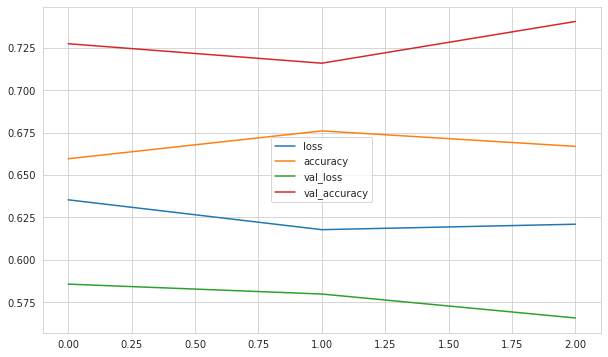

In [44]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()